In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from torchvision import transforms


class MushroomDataset(Dataset):
    """Кастомный датасет для работы с папками классов"""
    def __init__(self, root_dir, transform=None, target_size=None):
        """
        Args:
            root_dir (str): Путь к папке с классами
            transform: Первичная аугментации для изображений
            target_size (tuple): Размер для ресайза изображений
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        
        # Получаем список классов (папок)
        self.ediable_cls = sorted([d for d in os.listdir(root_dir)   if os.path.isdir(os.path.join(root_dir, d))])
        self.ediable2idx = {cls_name: idx for idx, cls_name in enumerate(self.ediable_cls)}
        
        self.mushroom_cls = [os.listdir(os.path.join(root_dir, dir_name)) for dir_name in self.ediable_cls]
        self.mushroom_cls = [d for mushdir in self.mushroom_cls for d in mushdir]        
        self.mushroom2idx = {cls_name: idx for idx, cls_name in enumerate(self.mushroom_cls)}

        
        # Собираем все пути к изображениям
        self.images = []
        self.labels: list[dict] = [] 
        
        for ed_name in self.ediable_cls:
            ediable_dir = os.path.join(root_dir, ed_name)
            ediable_id = self.ediable2idx[ed_name]

            for mush_name in os.listdir(ediable_dir):
                class_dir = os.path.join(ediable_dir, mush_name)
                mush_id = self.mushroom2idx[mush_name]
                
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                        img_path = os.path.join(class_dir, img_name)
                        self.images.append(img_path)
                        self.labels.append({'ed_id': ediable_id,
                                            'mush_id': mush_id})
                    
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # Загружаем изображение
        image = Image.open(img_path).convert('RGB')
        
        # Ресайзим изображение
        if self.target_size:
            image = image.resize(self.target_size, Image.Resampling.LANCZOS)
        
        # Применяем аугментации
        if self.transform:
            image = self.transform(image)

        '''СТАВИМ ТОЛЬКО!!! ed_id '''
        return image, label['ed_id']
    
    def get_mushrooms_name(self):
        """Возвращает список имен видов грибов"""
        return self.mushroom_cls

    def get_ediable_name(self):
        """Возвращает список о съедобности"""
        return self.ediable_cls

In [2]:
# Загрузка датасета без аугментаций с преобразованием PIL --> torch.tensor()
transform = transforms.ToTensor()

root_train = 'mushrooms_small\\mushroom_dataset'
data = MushroomDataset(root_train, transform=transform, target_size=(224, 224))

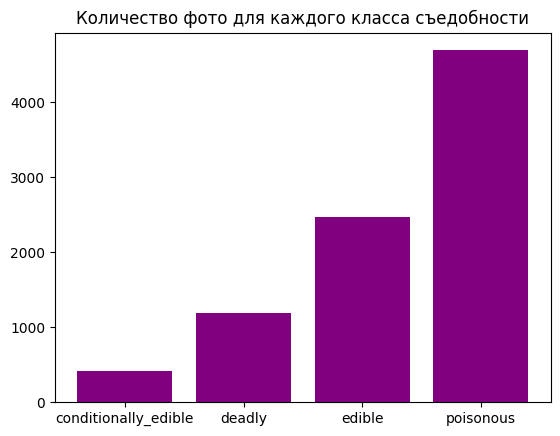

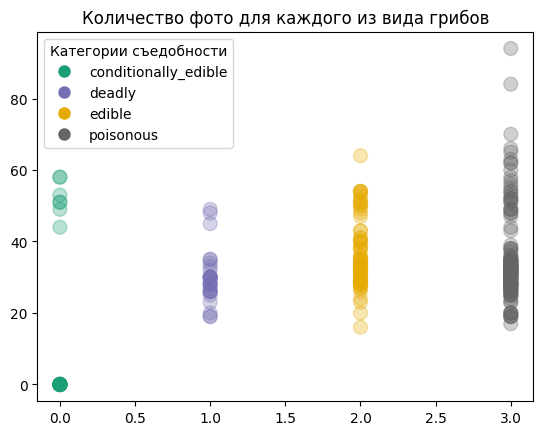

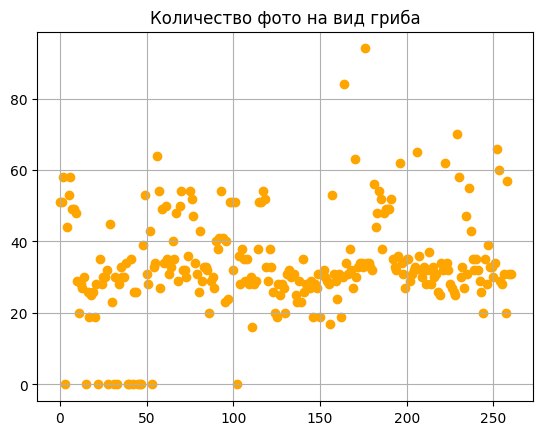

In [3]:
import matplotlib.pyplot as plt

ed_count = [0]*len(data.get_ediable_name())
mush_count = [0] * len(data.get_mushrooms_name())
mush_ed_cls = [0] * len(data.get_mushrooms_name())
index = -1
flag = None


for elem in data.labels:
    ed, mush = elem['ed_id'], elem['mush_id']
    ed_count[ed] += 1
    mush_count[mush] += 1

    if flag != ed:
        flag = ed
        index += 1
    mush_ed_cls[mush] = index



plt.title('Количество фото для каждого класса съедобности')
plt.bar(data.get_ediable_name(), ed_count, color='purple')
plt.show(data.get_ediable_name())


cmap = plt.get_cmap('Dark2', 4)  
colors = [cmap(i) for i in range(4)]

plt.title('Количество фото для каждого из вида грибов')
plt.scatter(mush_ed_cls, mush_count, alpha=0.3, c=mush_ed_cls, s=100, cmap=cmap)
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label=data.get_ediable_name()[i], 
               markerfacecolor=colors[i], markersize=10) 
    for i in range(len(data.get_ediable_name()))
]

plt.legend(handles=legend_elements, title='Категории съедобности')
plt.show()

plt.title('Количество фото на вид гриба')
plt.grid()
plt.scatter(range(len(mush_count)), mush_count, c='orange')
plt.show()

На графиках видно, что больше всего изображений __ядовитых__ грибов. \
Также видно, что большая часть папок содержит 20-60 изображений


## Создаем CNN с residual связями

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class MushroomCNNResNetClassifier(nn.Module):
    def __init__(self, input_channels=3, num_cls=4, drop_coef=0.25):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=input_channels, 
                                              out_channels=64, 
                                              kernel_size=3, 
                                              stride=1, 
                                              padding=1),
                                   nn.BatchNorm2d(64))
        
        
        self.layer2 = nn.Sequential(nn.Conv2d(64, 128, 5, 1, 2), 
                                    nn.BatchNorm2d(128))
        
        self.layer3 = nn.Sequential(nn.Conv2d(128, 256, 5, 1, 2), 
                            nn.BatchNorm2d(256))
        
        self.layer4 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), 
                            nn.BatchNorm2d(256))       

        self.layer5 = nn.Sequential(nn.Conv2d(256, 128, 5, 1, 2), 
                    nn.BatchNorm2d(128))  
        
        self.layer6 = nn.Sequential(nn.Conv2d(128, 64, 3, 1, 1), 
                                    nn.BatchNorm2d(64))    

        self.layer7 = nn.Sequential(nn.Conv2d(64, 32, 3, 1, 1), 
                            nn.BatchNorm2d(32))
               
        
        self.fc1 = nn.Linear(32*28*28, num_cls)

        # Дополнительные функции
        self.pool2x2 = nn.MaxPool2d(2, 2)
        self.avgpool2x2 = nn.AvgPool2d(2,2)
        self.dropout = nn.Dropout(drop_coef)
        self.shortcut1 = self.__shortcut(64, 256)
        self.shortcut2 = self.__shortcut(256, 128)
        self.shortcut3 = self.__shortcut(128, 32)
        # F.relu !!!

    def __shortcut(self, in_channels, out_channels):
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
                             nn.BatchNorm2d(out_channels))

    def forward(self, x):
        x = F.relu(self.layer1(x)) # [3, 224, 224] --> [64, 224, 224]
        
        residual = x # [64, 224, 224]
        
        x = self.dropout(F.relu(self.layer2(x))) # [64, 224, 224] --> [128, 224, 224]
        x = self.avgpool2x2(F.relu(self.layer3(x))) # [128, 224, 224] --> [256, 112, 112]


        residual = self.avgpool2x2(self.shortcut1(residual))
        x = x + residual  # [256, 112, 112]
        
        residual = x  # [256, 112, 112]
        
        x = self.dropout(F.relu(self.layer4(x))) # [256, 112, 112] --> same
        x = self.pool2x2(F.relu(self.layer5(x))) # [256, 112, 112] --> [128, 56, 56]

        residual = self.pool2x2(self.shortcut2(residual))
        x = x + residual  # [128, 56, 56]
        residual = x   # [128, 56, 56]

        x = self.dropout(F.relu(self.layer6(x)))   # [128, 56, 56] --> [64, 56, 56]
        x = self.avgpool2x2(F.relu(self.layer7(x))) # [64, 56, 56] --> [32, 28, 28]

        residual = self.avgpool2x2(self.shortcut3(residual))
        x = x + residual  #  [32, 28, 28]

        
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


def run_epoch(model, data_loader, criterion, optimizer=None, device='cuda:0', is_test=False):
    if is_test:
        model.eval()
    else:
        model.train()
    
    total_loss = 0
    correct = 0
    total = 0
    
    # Переносим модель на устройство 
    model.to(device)
    
    for batch_idx, (data, target) in tqdm(enumerate(data_loader)):
        data, target = data.to(device), target.to(device)
        
        if not is_test and optimizer is not None:
            optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        if not is_test and optimizer is not None:
            loss.backward()
            optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    
    return total_loss / len(data_loader), correct / total


def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cuda:0'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device, is_test=True)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    } 

In [8]:
CNNResNet = MushroomCNNResNetClassifier()

from torch.utils.data import random_split

train_size = int(0.8 * len(data))  
test_size = len(data) - train_size 

# Делим на train, test выборки
train_dataset, test_dataset = random_split(data, [train_size, test_size])

# Создаём DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [65]:
from torchsummary import summary
summary(CNNResNet.to('cuda:0'), input_size=(3, 224, 224))  # Указываем размер входного тензора (каналы, H, W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
            Conv2d-3        [-1, 128, 224, 224]         204,928
       BatchNorm2d-4        [-1, 128, 224, 224]             256
           Dropout-5        [-1, 128, 224, 224]               0
            Conv2d-6        [-1, 256, 224, 224]         819,456
       BatchNorm2d-7        [-1, 256, 224, 224]             512
         AvgPool2d-8        [-1, 256, 112, 112]               0
            Conv2d-9        [-1, 256, 224, 224]          16,384
      BatchNorm2d-10        [-1, 256, 224, 224]             512
        AvgPool2d-11        [-1, 256, 112, 112]               0
           Conv2d-12        [-1, 256, 112, 112]         590,080
      BatchNorm2d-13        [-1, 256, 112, 112]             512
          Dropout-14        [-1, 256, 1

А до этого была моя ошибка, из-за чего модель **ОЧЕНЬ** долго обрабатывала 2 изображения 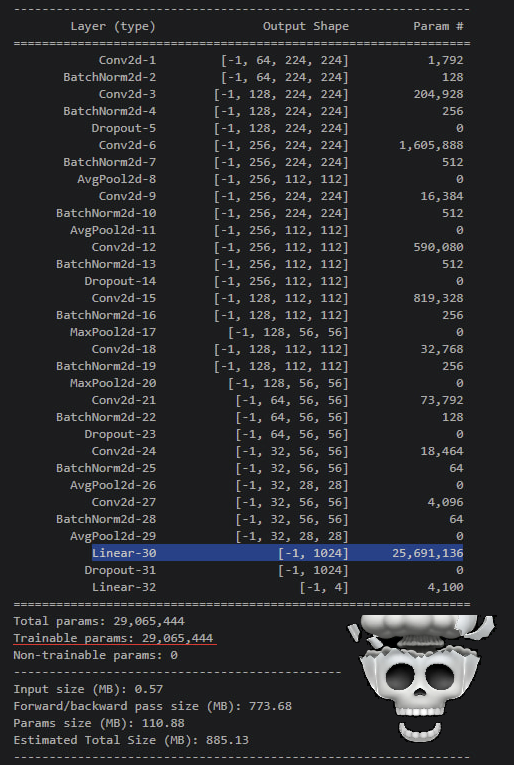

In [39]:
metrics = train_model(CNNResNet, train_loader, test_loader, epochs=2, lr=0.001, device='cuda:0')

  0%|                                                                                            | 0/2 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [17]:
import torch
import matplotlib.pyplot as plt


def plot_training_history(history):
    """Визуализирует историю обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['test_losses'], label='Test Loss')
    ax1.set_title('Loss')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(history['train_accs'], label='Train Acc')
    ax2.plot(history['test_accs'], label='Test Acc')
    ax2.set_title('Accuracy')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

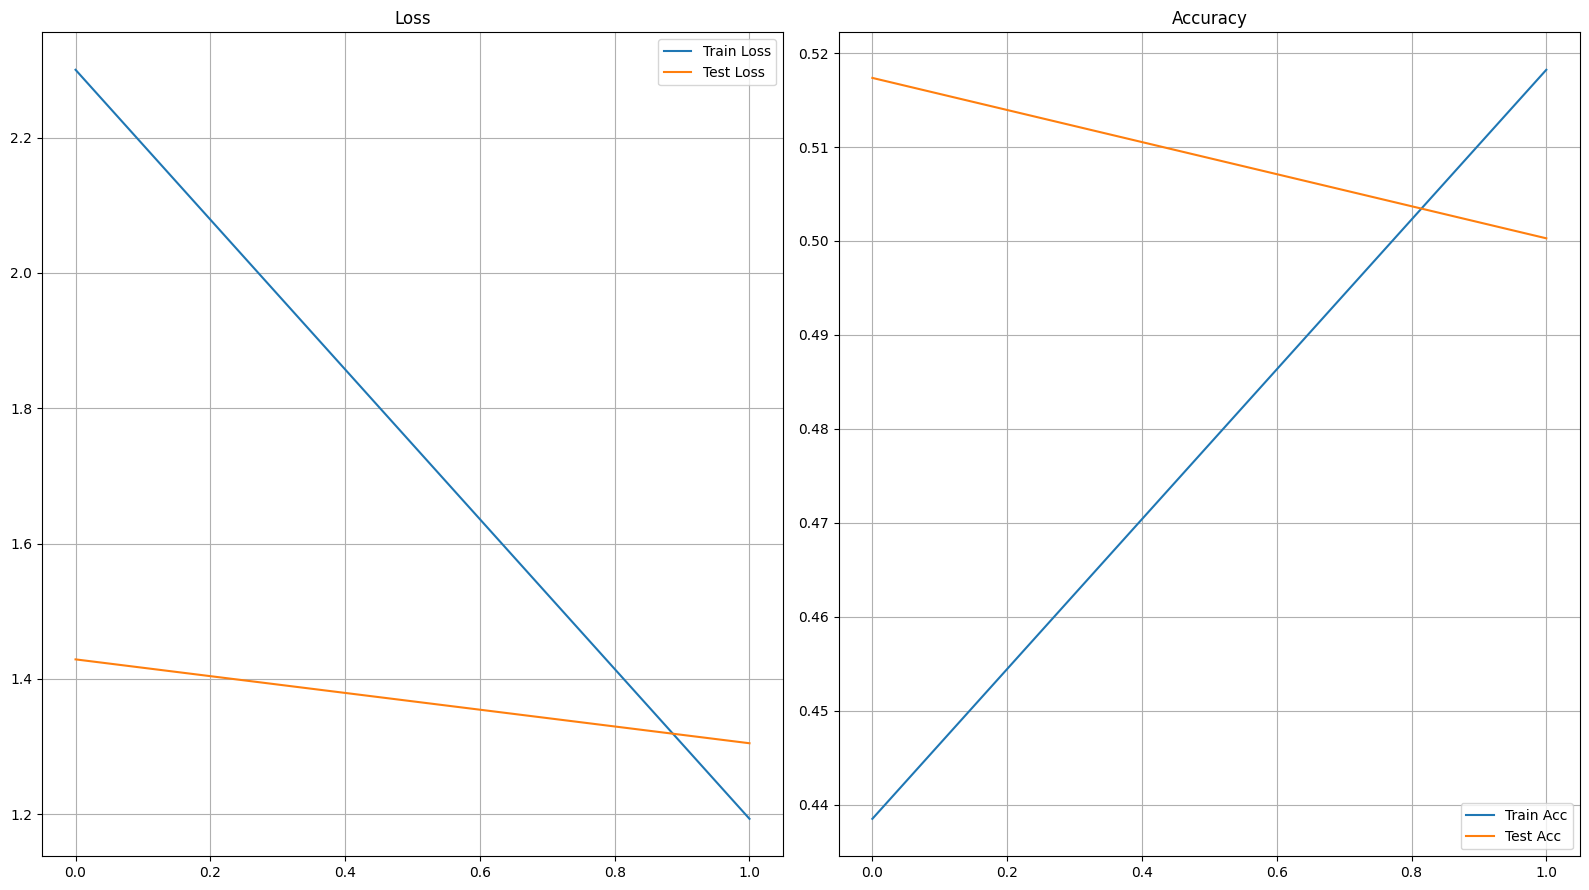

In [26]:
plot_training_history(metrics)

### После обучения в Colab

In [50]:
a = torch.load('last_checkpoit_19epoch.pt')

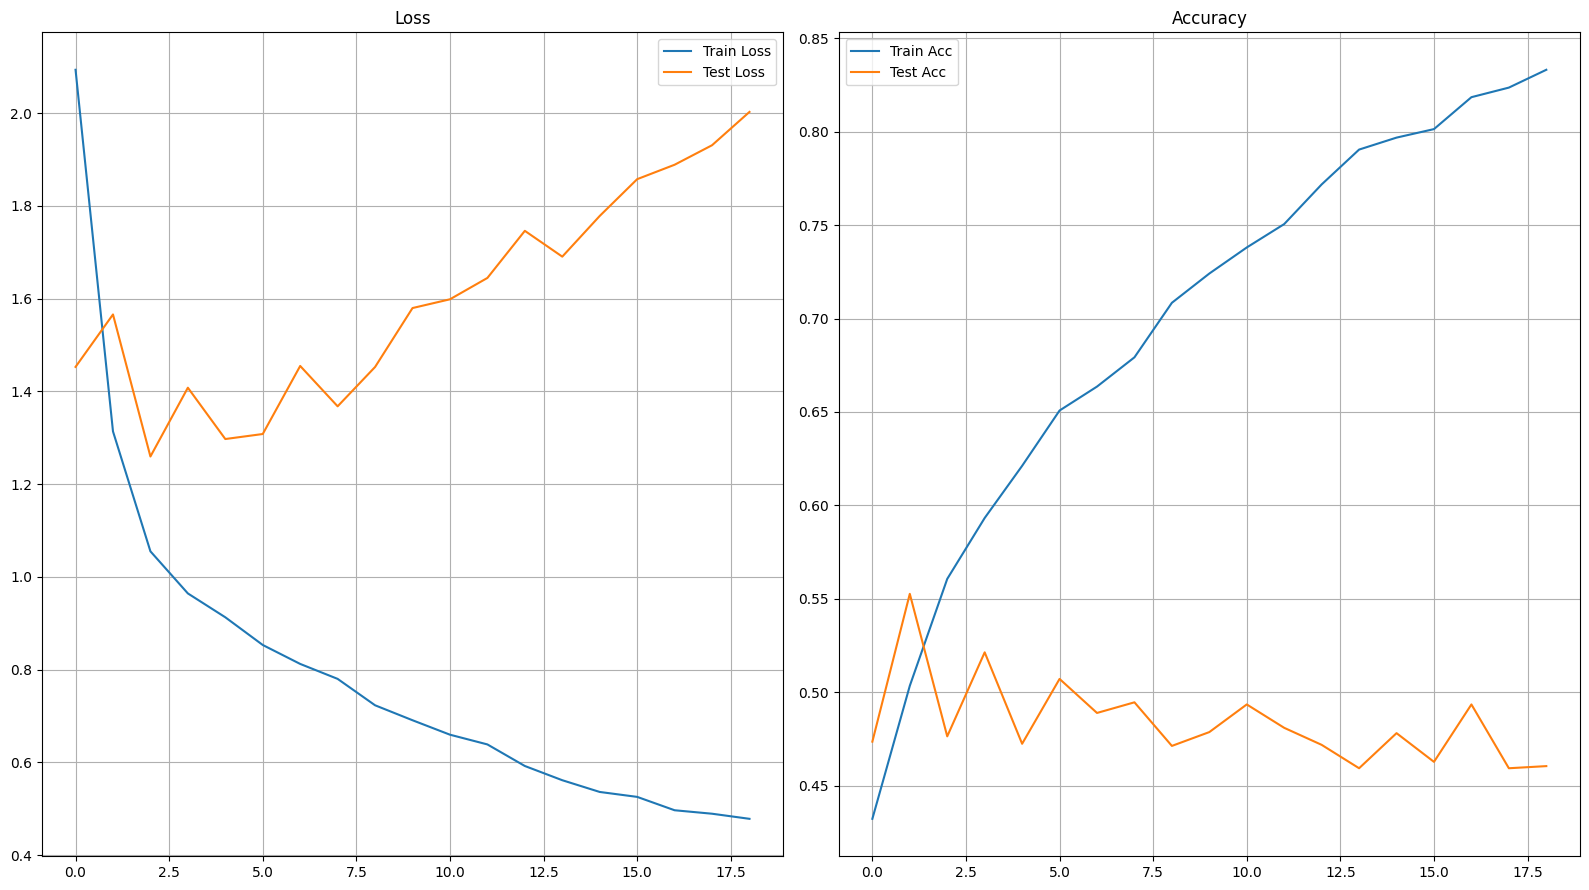

In [52]:
model = MushroomCNNResNetClassifier()
model.load_state_dict(a['model_params'])
losses = {'train_losses': a['train_losses'],
          'train_accs': a['train_accs'],
          'test_losses': a['test_losses'],
          'test_accs': a['test_accs']}
plot_training_history(losses)

### Здесь заметно переобучение - losses на test выборке улетают вверх, когда как точность остается ниже 0.5
Попробуем уменьшить количество параметров модели и уменьшить ее глубину

In [57]:
class CompactMushroomCNN(nn.Module):
    def __init__(self, num_cls=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_cls)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [67]:
compactCNN = CompactMushroomCNN()
summary(compactCNN.to('cuda:0'), input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,856
      BatchNorm2d-10          [-1, 128, 56, 56]             256
             ReLU-11          [-1, 128, 56, 56]               0
AdaptiveAvgPool2d-12            [-1, 128, 1, 1]               0
           Linear-13                    [-1, 4]             516
Total params: 94,212
Trainable params: 

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


def run_epoch(model, data_loader, criterion, optimizer=None, device='cuda:0', is_test=False):
    if is_test:
        model.eval()
    else:
        model.train()

    total_loss = 0
    correct = 0
    total = 0

    # Переносим модель на устройство
    model.to(device)

    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)

        if not is_test and optimizer is not None:
            optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        if not is_test and optimizer is not None:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    return total_loss / len(data_loader), correct / total


def train_model(model:nn.Module, train_loader, test_loader, epochs=10, lr=0.001, device='cuda:0'):
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=lr)
    # Поробуем SGD
    optimizer = optim.SGD(model.parameters(), lr=0.007, momentum=0.9, weight_decay=0.0002)

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    best_acc = 0.0

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device, is_test=True)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        torch.save({
                'epoch': epoch+1,
                'model_params': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_losses': train_losses,
                'train_accs': train_accs,
                'test_losses': test_losses,
                'test_accs': test_accs
            }, f'compactCNN_last_checkpoit.pt')


        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                'epoch': epoch+1,
                'model_params': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'loss': test_loss,
                'accuracy': test_acc
            }, f'compactCNN_best_model.pt')


    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    }

In [97]:
# Создаём DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [99]:
metric_compactcnn  = train_model(compactCNN, train_loader, test_loader, epochs=20, lr=0.0005, device='cuda:0')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [15:36<00:00, 46.81s/it]


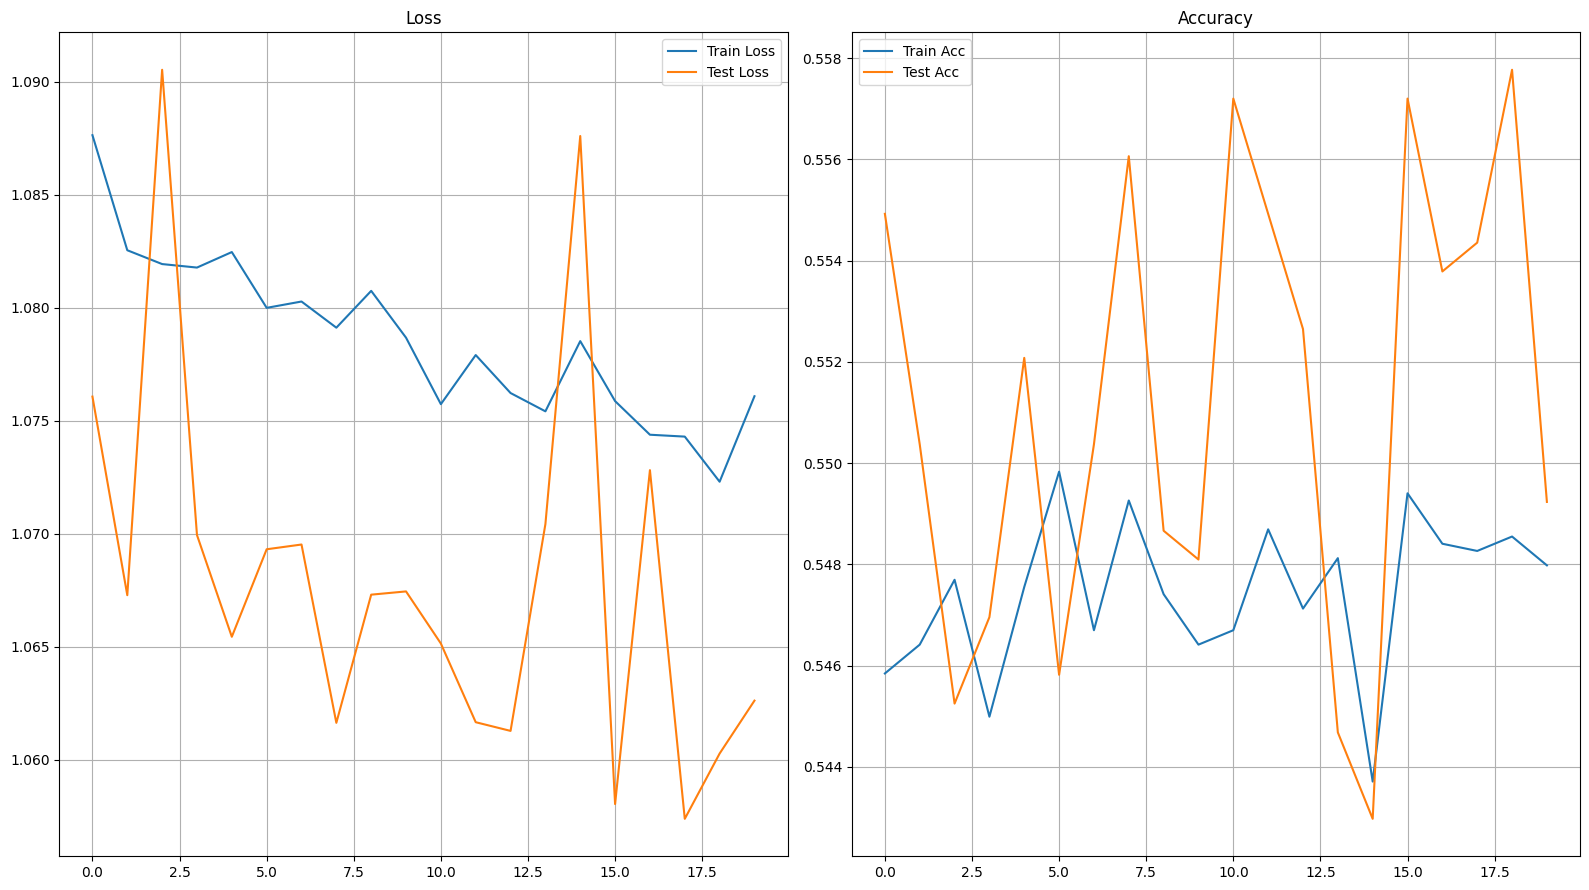

In [103]:
plot_training_history(metric_compactcnn)

### Уже получше, но метрики скачат из-за стохастического градиента, поробуем Adam

In [115]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


def run_epoch(model, data_loader, criterion, optimizer=None, device='cuda:0', is_test=False):
    if is_test:
        model.eval()
    else:
        model.train()

    total_loss = 0
    correct = 0
    total = 0

    # Переносим модель на устройство
    model.to(device)

    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)

        if not is_test and optimizer is not None:
            optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        if not is_test and optimizer is not None:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    return total_loss / len(data_loader), correct / total


def train_model(model:nn.Module, train_loader, test_loader, epochs=10, lr=0.001, device='cuda:0'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0002)

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    best_acc = 0.0

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device, is_test=True)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        torch.save({
                'epoch': epoch+1,
                'model_params': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_losses': train_losses,
                'train_accs': train_accs,
                'test_losses': test_losses,
                'test_accs': test_accs
            }, f'AdamcompactCNN_last_checkpoit.pt')


        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                'epoch': epoch+1,
                'model_params': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'loss': test_loss,
                'accuracy': test_acc
            }, f'AdamcompactCNN_best_model.pt')


    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    }

In [108]:
AdamcompactCNN = CompactMushroomCNN()
AdamcompactCNN_metric = train_model(AdamcompactCNN, train_loader, test_loader, epochs=20, lr=0.0007, device='cuda:0')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [14:33<00:00, 43.67s/it]


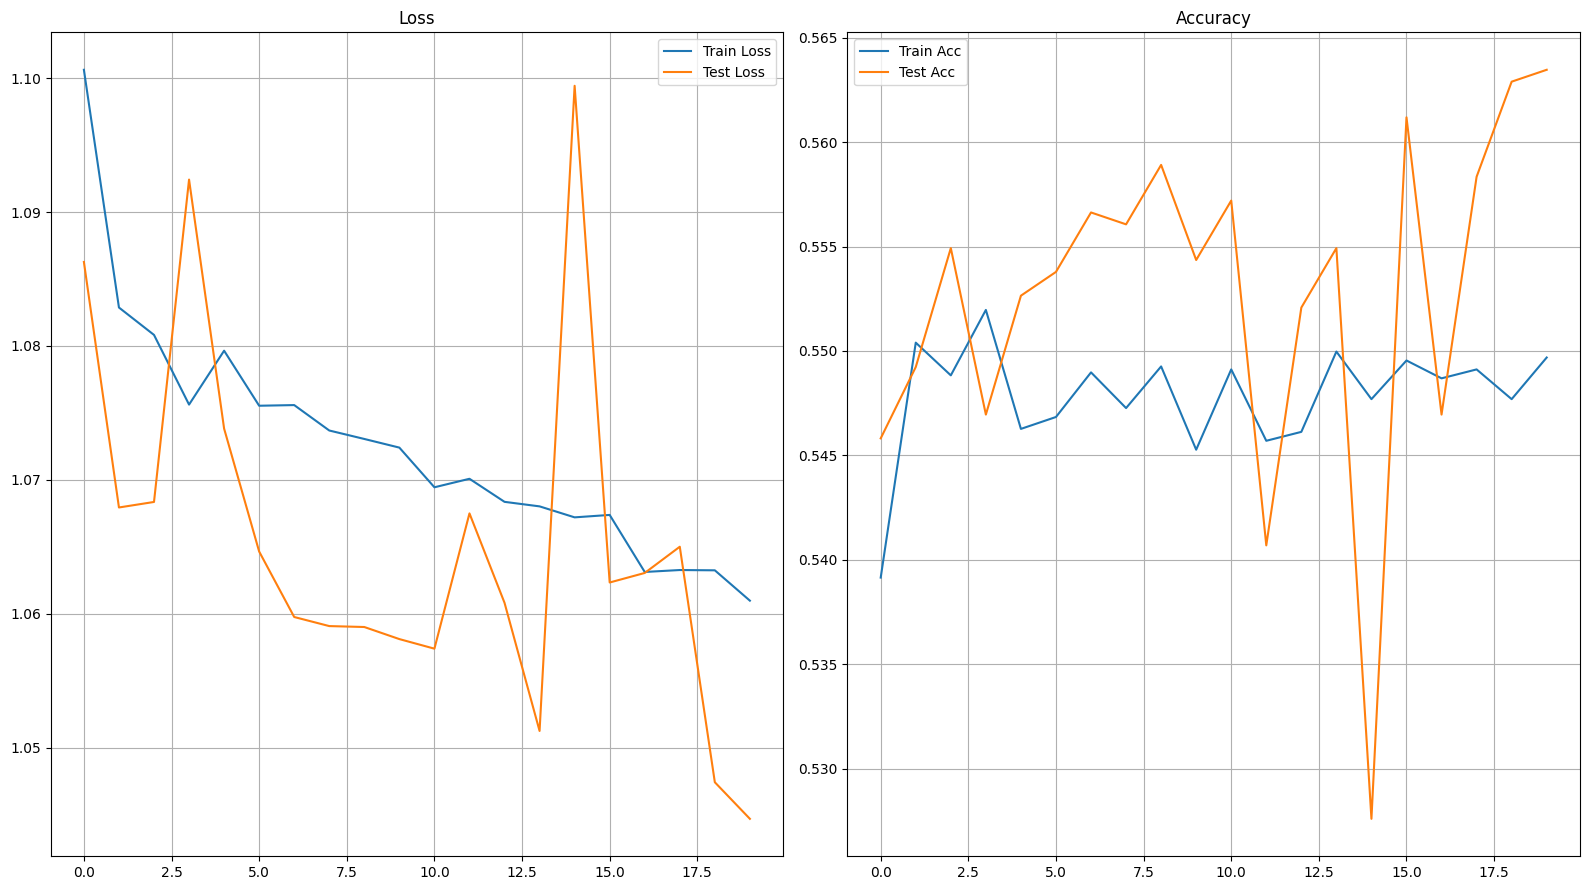

In [110]:
plot_training_history(AdamcompactCNN_metric)

### Попробуем с ResNetCNN, но уменьшим кол-во параметров 


In [184]:
import torch.nn as nn
import torch.nn.functional as F


class SmallMushroomCNNResNetClassifier(nn.Module):
    def __init__(self, input_channels=3, num_cls=4, drop_coef=0.25):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=input_channels, 
                                              out_channels=32, 
                                              kernel_size=3, 
                                              stride=1, 
                                              padding=1),
                                   nn.BatchNorm2d(32))
        
        
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, 5, 1, 2), 
                                    nn.BatchNorm2d(64))
        
        self.layer3 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1), 
                            nn.BatchNorm2d(128))   


        self.layer4 = nn.Sequential(nn.Conv2d(128, 32, 3, 1, 1), 
                            nn.BatchNorm2d(32))
               
        
        self.fc1 = nn.Linear(32*56*56, num_cls)

        # Дополнительные функции
        self.avgpool2x2 = nn.AvgPool2d(2,2)
        self.dropout = nn.Dropout(drop_coef)
        self.shortcut1 = self.__shortcut(3, 64)
        self.shortcut2 = self.__shortcut(64, 32)

    def __shortcut(self, in_channels, out_channels):
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
                             nn.BatchNorm2d(out_channels))

    def forward(self, x):
        residual = x # [3, 224, 224]
        x = F.relu(self.layer1(x)) #[32, 224, 224]
        x = self.dropout(self.avgpool2x2(F.relu(self.layer2(x)))) #[64, 112, 112]
        residual = self.shortcut1(residual)
        x = x + self.avgpool2x2(residual)
        
        residual = x
        x = F.relu(self.layer3(x)) #[128, 112, 112]
        x = self.dropout(self.avgpool2x2(F.relu(self.layer4(x)))) #[32, 112, 112]
        residual = self.avgpool2x2(self.shortcut2(residual))
        x = x + residual
        
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

In [186]:
m = SmallMushroomCNNResNetClassifier().to('cuda:0')
summary(m, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
            Conv2d-3         [-1, 64, 224, 224]          51,264
       BatchNorm2d-4         [-1, 64, 224, 224]             128
         AvgPool2d-5         [-1, 64, 112, 112]               0
           Dropout-6         [-1, 64, 112, 112]               0
            Conv2d-7         [-1, 64, 224, 224]             192
       BatchNorm2d-8         [-1, 64, 224, 224]             128
         AvgPool2d-9         [-1, 64, 112, 112]               0
           Conv2d-10        [-1, 128, 112, 112]          73,856
      BatchNorm2d-11        [-1, 128, 112, 112]             256
           Conv2d-12         [-1, 32, 112, 112]          36,896
      BatchNorm2d-13         [-1, 32, 112, 112]              64
        AvgPool2d-14           [-1, 32,

In [180]:
def train_model(model:nn.Module, train_loader, test_loader, epochs=10, lr=0.001, device='cuda:0'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0002)

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    best_acc = 0.0

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device, is_test=True)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        torch.save({
                'epoch': epoch+1,
                'model_params': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_losses': train_losses,
                'train_accs': train_accs,
                'test_losses': test_losses,
                'test_accs': test_accs
            }, f'AdamSmallCNNResNet_last_checkpoit.pt')


        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                'epoch': epoch+1,
                'model_params': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'loss': test_loss,
                'accuracy': test_acc
            }, f'AdamSmallCNNResNet_best_model.pt')


    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    }

In [196]:
# Создаём DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [198]:
smallCNNResNet = SmallMushroomCNNResNetClassifier()
smallCNNResNet_metric = train_model(smallCNNResNet, train_loader, test_loader, epochs=20, lr=0.0007, device='cuda:0')


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [44:39<00:00, 133.95s/it]


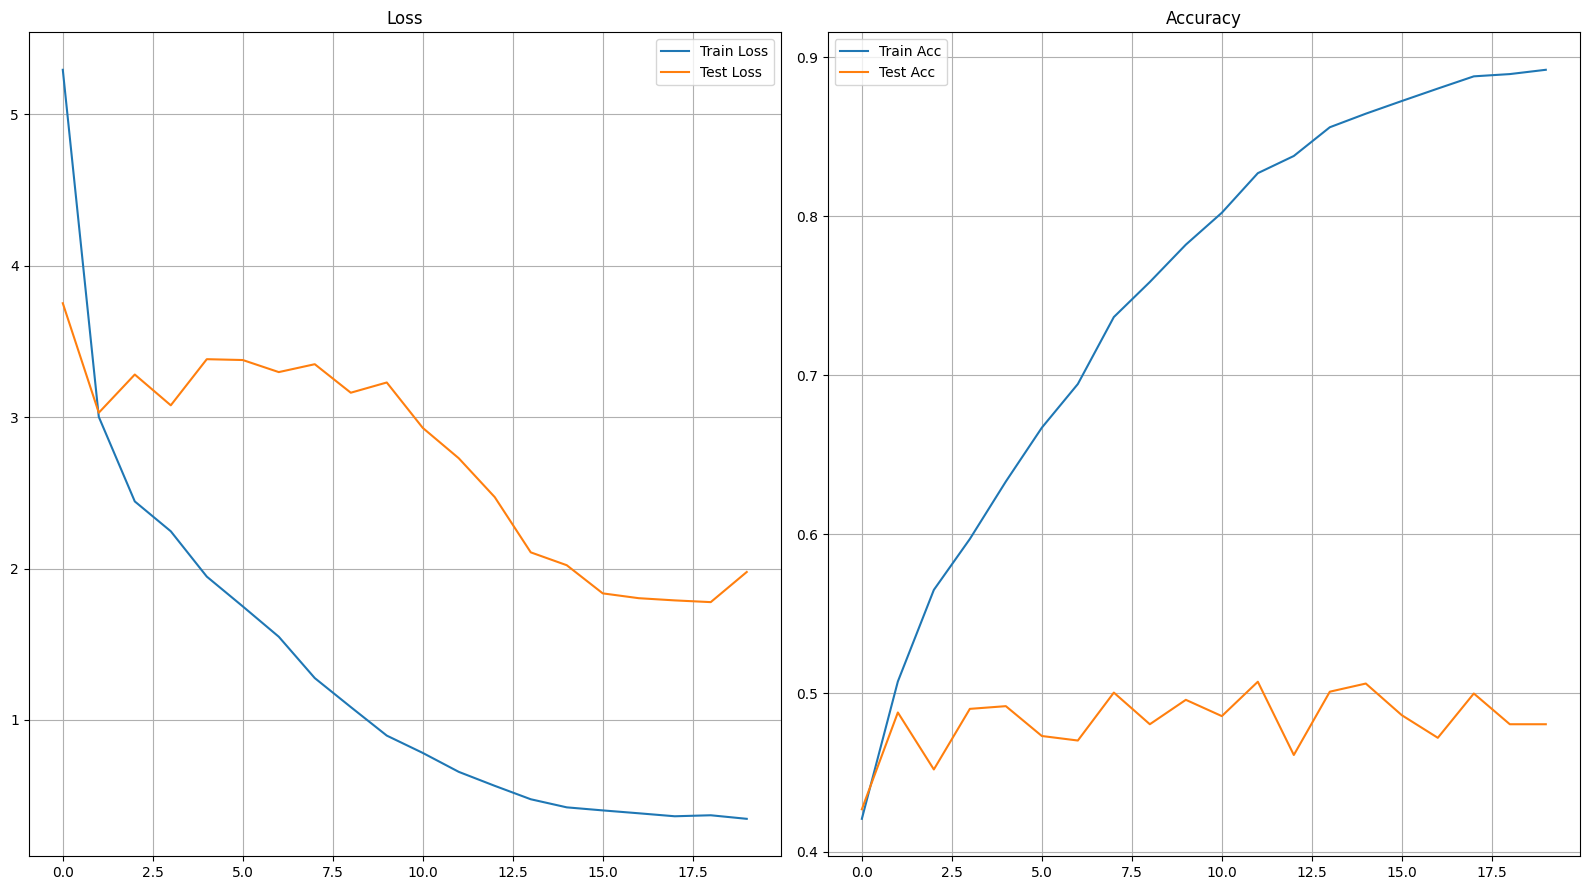

In [203]:
plot_training_history(smallCNNResNet_metric)

### resnet18
